In [1]:
import psycopg2
import os
import csv
import time
import numpy as np
import pandas as pd
import pickle

from category_encoders import OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import tensorflow as tf
import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GRU, Dropout, Input, BatchNormalization, Activation
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [48]:
conn = psycopg2.connect(
  host='192.168.35.23',
  dbname='train_db',
  user='project4',
  password='abcdqwer',
  port='5432'
)

In [49]:
dataset = pd.read_sql("SELECT * FROM train_cong", conn)
dataset_cp = dataset.copy()

conn.close()

/var/folders/5y/8vxkxcq10jbbp_61mxm4tcqw0000gn/T/ipykernel_37287/557139081.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  dataset = pd.read_sql("SELECT * FROM train_cong", conn)


In [50]:
dataset

,id,number_asc,week,line,st_code,st_name,clss,time,congestion
0,1,1,평일,1,150,서울역,상선,1000,26.6
1,2,1,평일,1,150,서울역,상선,1030,23.4
2,3,1,평일,1,150,서울역,상선,1100,22.4
3,4,1,평일,1,150,서울역,상선,1130,22.1
4,5,1,평일,1,150,서울역,상선,1200,21.5
...,...,...,...,...,...,...,...,...,...
63043,63044,1,일요일,8,2827,모란,하선,730,0.0
63044,63045,1,일요일,8,2827,모란,하선,800,0.0
63045,63046,1,일요일,8,2827,모란,하선,830,0.0
63046,63047,1,일요일,8,2827,모란,하선,900,0.0


In [51]:
dataset.drop(['id', 'number_asc', 'st_name'], axis=1, inplace=True, errors='ignore')
dataset.sort_values(['week', 'st_code', 'clss', 'time'], inplace=True)
dataset.reset_index(drop=True, inplace=True)

In [52]:
# dataset_cp[dataset_cp['line'] == 15][['st_code', 'st_name','clss', 'week']].value_counts()

In [53]:
# 이동 방향에 따른 역번호 증가
# 1호선(상선 증가) , 2호선(내선 증가), 3호선(하선 증가), 4호선(상선 증가), 5호선(하선 증가), 6호선(하선 증가), 7호선(하선 증가), 8(하선 증가)
# line 13(2호선), line 14(2호선), line 15(5호선)

dataset = dataset.replace({'평일':1, '토요일':2, '일요일':3, '상선':1, '하선':2, '내선':3, '외선':4})

In [54]:
x_train = dataset.drop('congestion', axis=1)
y_train = dataset['congestion']

scaler = StandardScaler()
x_scaled = scaler.fit_transform(x_train)

In [55]:
model_path = '/Users/kkangjun/Desktop/Study/CodeStates/Project/Project4/codestates_Project4/cong_app/ai_model'

In [56]:
import pickle

with open(model_path + '/scaler_pickle.pkl', 'wb') as pklf:
  pickle.dump(scaler, pklf)

In [57]:
x_train

,week,line,st_code,clss,time
0,3,1,150,1,530
1,3,1,150,1,600
2,3,1,150,1,630
3,3,1,150,1,700
4,3,1,150,1,730
...,...,...,...,...,...
63043,1,8,2827,2,2130
63044,1,8,2827,2,2200
63045,1,8,2827,2,2230
63046,1,8,2827,2,2300


In [58]:
x_train.shape, y_train.shape

((63048, 5), (63048,))

In [59]:
def base_model():
  inputs = Input(shape=(x_train.shape[1]))
  
  layer = Dense(512, kernel_initializer='he_normal')(inputs)
  layer = BatchNormalization()(layer)
  layer = Activation('relu')(layer)
  # layer = Dropout(0.2)(layer)
  
  layer = Dense(256, kernel_initializer='he_normal')(layer)
  layer = BatchNormalization()(layer)
  layer = Activation('relu')(layer)
  # layer = Dropout(0.2)(layer)
  
  layer = Dense(128, kernel_initializer='he_normal')(layer)
  layer = BatchNormalization()(layer)
  layer = Activation('relu')(layer)
  # layer = Dropout(0.2)(layer)
  
  layer = Dense(64, kernel_initializer='he_normal')(layer)
  layer = BatchNormalization()(layer)
  layer = Activation('relu')(layer)
  # layer = Dropout(0.2)(layer)
  
  outputs = Dense(1, name='output')(layer)
  
  model = Model(inputs=inputs, outputs=outputs)
  model.compile(optimizer='adam', loss='mean_squared_error')
  
  return model

In [60]:
early_stop = keras.callbacks.EarlyStopping(monitor='loss', patience=5, verbose=1)
save_best = keras.callbacks.ModelCheckpoint(filepath=model_path + '/latest_model.h5', monitor='loss', verbose=1,
                                            save_best_only=True, save_weights_only=False)

model = base_model()

model.fit(x_scaled, y_train, batch_size=128, epochs=300, callbacks=[early_stop, save_best])

Epoch 1/300


2023-04-10 14:06:34.964980: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


493/493 [==============================] - ETA: 0s - loss: 321.9554
Epoch 1: loss improved from inf to 321.95541, saving model to /Users/kkangjun/Desktop/Study/CodeStates/Project/Project4/codestates_Project4/cong_app/ai_model/latest_model.h5
493/493 [==============================] - 7s 13ms/step - loss: 321.9554
Epoch 2/300
493/493 [==============================] - ETA: 0s - loss: 157.0758
Epoch 2: loss improved from 321.95541 to 157.07582, saving model to /Users/kkangjun/Desktop/Study/CodeStates/Project/Project4/codestates_Project4/cong_app/ai_model/latest_model.h5
493/493 [==============================] - 6s 12ms/step - loss: 157.0758
Epoch 3/300
492/493 [============================>.] - ETA: 0s - loss: 151.9651
Epoch 3: loss improved from 157.07582 to 151.99036, saving model to /Users/kkangjun/Desktop/Study/CodeStates/Project/Project4/codestates_Project4/cong_app/ai_model/latest_model.h5
493/493 [==============================] - 6s 12ms/step - loss: 151.9904
Epoch 4/300
491/493

In [ ]:
dataset_cp[(dataset_cp['st_code'] == 222) & (dataset_cp['time'] == 1800)]

In [4]:
model2 = tf.keras.models.load_model('../ai_model' + '/latest_model.h5')
scaler_pkl = None
with open('../ai_model' + '/scaler_pickle.pkl', 'rb') as pklf:
  scaler_pkl = pickle.load(pklf)

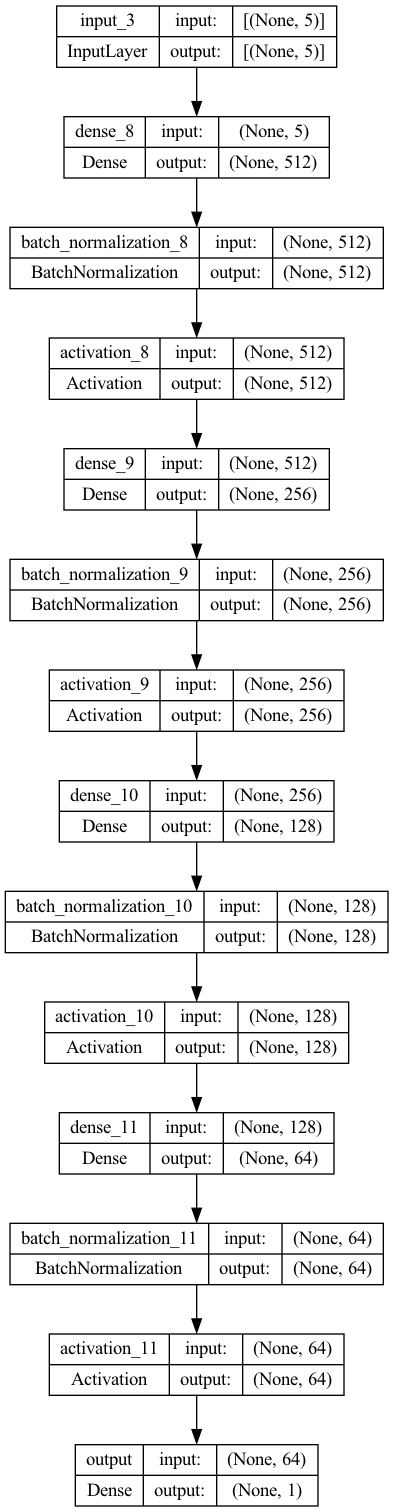

In [5]:
tf.keras.utils.plot_model(model2, show_shapes=True, to_file="../ai_model/model.png")

In [46]:
new_data = np.array([[1, 2, 211, 1, 1900]])
new_scaled = scaler_pkl.transform(new_data)

model2.predict(new_scaled)

1/1 [==============================] - 0s 113ms/step


/Users/kkangjun/miniforge3/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
2023-04-10 14:01:33.339029: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


array([[50.263256]], dtype=float32)

In [138]:
new_data = np.array([[1, 150, 2, 1800]])

pred = model2.predict(new_data)

1/1 [==============================] - 0s 9ms/step


In [8]:
float(pred)

32.71419143676758

In [9]:
round(float(pred), 2)

32.71

In [394]:
# seq_len = 37
# stride = 1
# batch_size = 37

# generator = TimeseriesGenerator(x_train, y_train, length=seq_len, stride=stride, batch_size=batch_size)

In [395]:
# def gru_model(layers=0):
#   inputs = Input(shape=(seq_len, x_train.shape[1]))
#   layer = GRU(64, activation='tanh')(inputs)
#   layer = Dropout(0.2)(layer)
  
#   for _ in range(layers):
#     layer = GRU(64, activation='tanh')(inputs)
#     layer = Dropout(0.2)(layer)
  
#   outputs = Dense(1, name='output')(layer)
  
#   model = Model(inputs=inputs, outputs=outputs)
  
#   model.compile(optimizer='adam', loss='mean_squared_error')
  
#   return model

In [ ]:
# model = gru_model(6)

# model.fit(generator, epochs=10)

In [ ]:
# new_data = np.array([[1, 1, 150, 1, 2000]])

# last_sequence = x_train[-(seq_len - 1):]
# new_sequence = np.concatenate((last_sequence, new_data), axis=0)

In [ ]:
# model.predict(new_data.reshape(1, 1, x_train.shape[1]))